In [2]:
# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

file_path = '../data/interest_rate_prediction.csv'

try:
    df = pd.read_csv(file_path, low_memory=False)
    print("Dataset loaded successfully. Here are the first 5 rows:")
    display(df.head())
    
    print("\n--- DataFrame Info ---")
    df.info()

except FileNotFoundError:
    print(f"Error: 파일을 찾을 수 없습니다. '{file_path}' 경로에 파일이 있는지 다시 한번 확인해주세요.")

Dataset loaded successfully. Here are the first 5 rows:


,loan_amnt,term,int_rate,grade,annual_inc,purpose,fico_range_low,fico_range_high
0,3600.0,36 months,13.99,C,55000.0,debt_consolidation,675.0,679.0
1,24700.0,36 months,11.99,C,65000.0,small_business,715.0,719.0
2,20000.0,60 months,10.78,B,63000.0,home_improvement,695.0,699.0
3,35000.0,60 months,14.85,C,110000.0,NaN,785.0,789.0
4,10400.0,60 months,22.45,F,104433.0,major_purchase,695.0,699.0



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   loan_amnt        1048563 non-null  float64
 1   term             1048563 non-null  object 
 2   int_rate         1048563 non-null  float64
 3   grade            1048563 non-null  object 
 4   annual_inc       1048563 non-null  float64
 5   purpose          1048562 non-null  object 
 6   fico_range_low   1048563 non-null  float64
 7   fico_range_high  1048563 non-null  float64
dtypes: float64(5), object(3)
memory usage: 64.0+ MB


In [3]:
# --- Data Type Conversion for Modeling ---

# Make a copy to ensure the original dataframe remains unchanged
df_processed = df.copy()

# 1. Handle missing values
# Drop rows with any null values since the count is very small
df_processed.dropna(inplace=True)

# 2. Convert 'term' from object to number
# Example: ' 36 months' -> 36
df_processed['term'] = df_processed['term'].apply(lambda term: int(term.strip().split()[0]))

# 3. Convert 'grade' from object to number (ordinal encoding)
# A is the best grade, so it gets the highest number.
grade_map = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df_processed['grade'] = df_processed['grade'].map(grade_map)

# 4. Convert 'purpose' from object to numbers (one-hot encoding)
# This creates new columns for each category
purpose_dummies = pd.get_dummies(df_processed['purpose'], prefix='purpose', drop_first=True)
df_processed = pd.concat([df_processed.drop('purpose', axis=1), purpose_dummies], axis=1)

# --- Confirm the result ---
print("Data preprocessing complete. All columns are now numeric.")
print("\n--- Processed DataFrame Info ---")
df_processed.info()

Data preprocessing complete. All columns are now numeric.

--- Processed DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 1048562 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1048562 non-null  float64
 1   term                        1048562 non-null  int64  
 2   int_rate                    1048562 non-null  float64
 3   grade                       1048562 non-null  int64  
 4   annual_inc                  1048562 non-null  float64
 5   fico_range_low              1048562 non-null  float64
 6   fico_range_high             1048562 non-null  float64
 7   purpose_credit_card         1048562 non-null  bool   
 8   purpose_debt_consolidation  1048562 non-null  bool   
 9   purpose_educational         1048562 non-null  bool   
 10  purpose_home_improvement    1048562 non-null  bool   
 11  purpose_house               

In [4]:
# --- Feature Engineering for FICO Score ---

# 1. Create a new 'fico_score' column by calculating the average of the high and low ranges.
df_processed['fico_score'] = (df_processed['fico_range_low'] + df_processed['fico_range_high']) / 2

# 2. Drop the original, now redundant, fico range columns.
df_processed.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace=True)


# --- Confirm the result ---
print("Created 'fico_score' and dropped original range columns.")
print("Here are the first 5 rows with the new 'fico_score' column:")

# Display the head of the dataframe to see the new column and other changes
display(df_processed.head())

Created 'fico_score' and dropped original range columns.
Here are the first 5 rows with the new 'fico_score' column:


,loan_amnt,term,int_rate,grade,annual_inc,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,fico_score
0,3600.0,36,13.99,5,55000.0,False,True,False,False,False,False,False,False,False,False,False,False,False,677.0
1,24700.0,36,11.99,5,65000.0,False,False,False,False,False,False,False,False,False,False,True,False,False,717.0
2,20000.0,60,10.78,6,63000.0,False,False,False,True,False,False,False,False,False,False,False,False,False,697.0
4,10400.0,60,22.45,2,104433.0,False,False,False,False,False,True,False,False,False,False,False,False,False,697.0
5,11950.0,36,13.44,5,34000.0,False,True,False,False,False,False,False,False,False,False,False,False,False,692.0


In [7]:
# Import necessary libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

# --- 1. Define Features (X) and Target (y) ---
# 'int_rate' is what we want to predict (y)
# All other columns will be used as features to predict the interest rate (X)
X = df_processed.drop('int_rate', axis=1)
y = df_processed['int_rate']

# --- 2. Split the data into training and testing sets ---
# 80% of the data will be used for training, 20% for testing
# random_state ensures we get the same split every time we run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Initialize and Train the LightGBM Regressor model ---
print("Training the LightGBM model...")
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
print("Training complete.")

# --- 4. Make predictions on the test data ---
y_pred = lgbm.predict(X_test)

# --- 5. Evaluate the model's performance ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation Results ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Training the LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 838849, number of used features: 16
[LightGBM] [Info] Start training from score 12.773269
Training complete.

--- Model Evaluation Results ---
Mean Absolute Error (MAE): 1.0582
Root Mean Squared Error (RMSE): 1.3774
R-squared (R²): 0.9195


In [8]:
# Import RandomizedSearchCV for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# --- 1. Define the Hyperparameter Grid ---
# We will search for the best parameters within these ranges.
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [-1, 10, 20, 30],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1]
}

# Initialize the base model
lgbm = lgb.LGBMRegressor(random_state=42)

# --- 2. Set up RandomizedSearchCV ---
# n_iter: Number of parameter settings that are sampled.
# cv: Number of folds for cross-validation.
# scoring: The metric to optimize for (negative MAE, because the function maximizes a score).
# n_jobs: Use all available CPU cores.
random_search = RandomizedSearchCV(
    lgbm, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, 
    random_state=42,
    verbose=1 # Shows the progress
)

print("Starting hyperparameter tuning...")
# --- 3. Fit the model to find the best parameters ---
random_search.fit(X_train, y_train)
print("Tuning complete.")

# --- 4. Get the best model and evaluate it ---
best_lgbm = random_search.best_estimator_
y_pred_tuned = best_lgbm.predict(X_test)

# Calculate new performance metrics
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n--- Best Hyperparameters Found ---")
print(random_search.best_params_)

print("\n--- Tuned Model Evaluation Results ---")
print(f"Mean Absolute Error (MAE): {mae_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.4f}")
print(f"R-squared (R²): {r2_tuned:.4f}")

print("\n--- Comparison with Default Model ---")
print(f"MAE Improved from {mae:.4f} to {mae_tuned:.4f}")
print(f"R² Improved from {r2:.4f} to {r2_tuned:.4f}")

Starting hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 838849, number of used features: 16
[LightGBM] [Info] Start training from score 12.773269
Tuning complete.

--- Best Hyperparameters Found ---
{'reg_lambda': 0.5, 'reg_alpha': 1, 'num_leaves': 50, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.1}

--- Tuned Model Evaluation Results ---
Mean Absolute Error (MAE): 1.0510
Root Mean Squared Error (RMSE): 1.3699
R-squared (R²): 0.9203

--- Comparison with Default Model ---
MAE Improved from 1.0582 to 1.0510
R² Improved from 0.9195 to 0.9203


--- Plotting Feature Importance ---


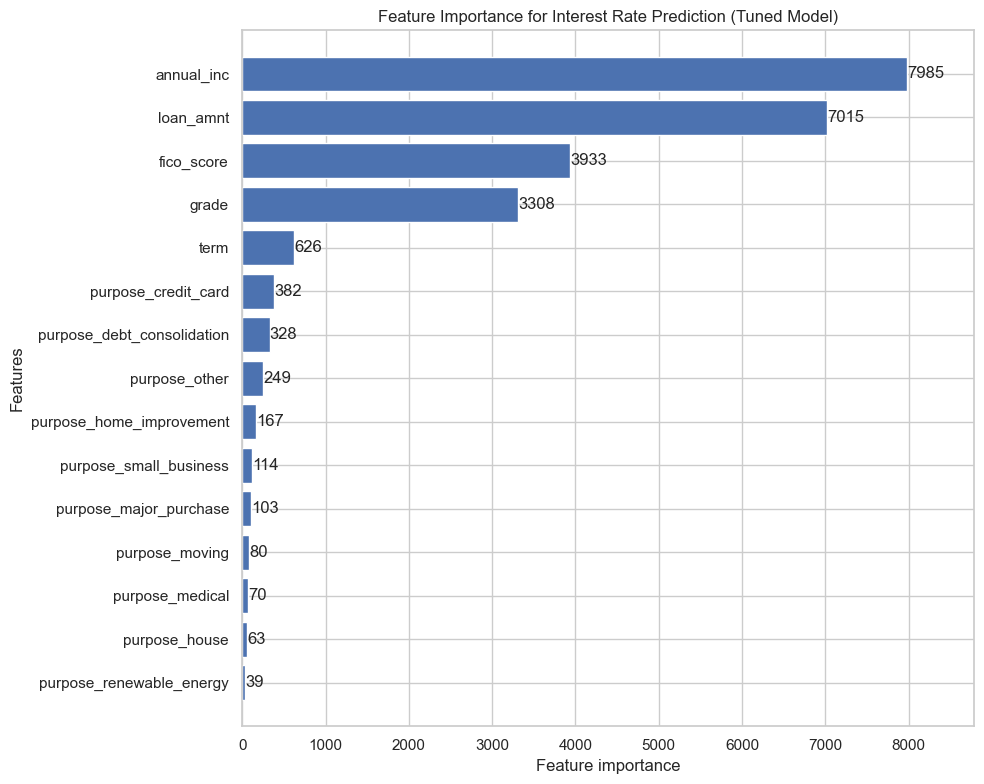

In [9]:
# Set a style for the plots
sns.set(style="whitegrid")

# --- 1. Plot Feature Importance ---
print("--- Plotting Feature Importance ---")
fig1, ax1 = plt.subplots(figsize=(10, 8))
lgb.plot_importance(best_lgbm, ax=ax1, max_num_features=15, height=0.8)
ax1.set_title("Feature Importance for Interest Rate Prediction (Tuned Model)")
plt.tight_layout()
# Save the figure to a file
plt.savefig("feature_importance.png")
plt.show()

C:\Users\junok\AppData\Local\Temp\ipykernel_8076\3158828036.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_comparison = results_df.groupby('Actual_Bin')[['Actual', 'Predicted']].mean()


--- Plotting Binned Average Comparison ---


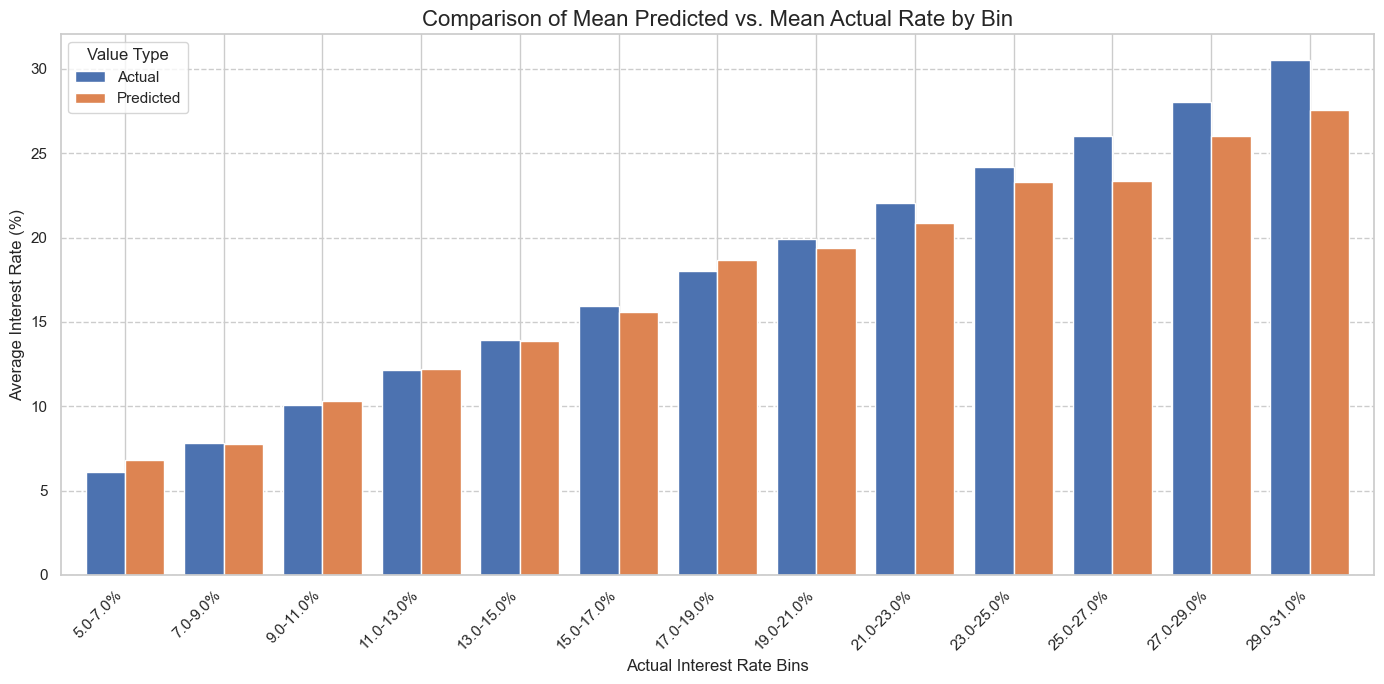

In [10]:
# --- Create a temporary DataFrame for easy plotting ---
# It's easier to work with a dataframe that has both actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_tuned
})

# --- Create bins for the actual interest rates ---
# We will group the actual rates into bins of size 2 (e.g., 5-7%, 7-9%, etc.)
bins = np.arange(5, results_df['Actual'].max() + 2, 2)
labels = [f'{i}-{i+2}%' for i in bins[:-1]]
results_df['Actual_Bin'] = pd.cut(results_df['Actual'], bins=bins, labels=labels, right=False)

# --- Group by the bins and calculate the mean for both columns ---
binned_comparison = results_df.groupby('Actual_Bin')[['Actual', 'Predicted']].mean()

# --- Plot the bar chart ---
print("--- Plotting Binned Average Comparison ---")
ax = binned_comparison.plot(kind='bar', figsize=(14, 7), width=0.8)

# Add title and labels
plt.title('Comparison of Mean Predicted vs. Mean Actual Rate by Bin', fontsize=16)
plt.xlabel('Actual Interest Rate Bins', fontsize=12)
plt.ylabel('Average Interest Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(title='Value Type')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# Save the figure to a file
plt.savefig("binned_comparison.png")
plt.show()

In [11]:
import joblib

# This assumes 'best_lgbm' (the tuned model from RandomizedSearchCV) 
# is available in your notebook's memory.

# --- 1. Save the final tuned model to a file ---
filename = 'interest_rate_model.joblib'
joblib.dump(best_lgbm, filename)

print(f"Model saved successfully to '{filename}'")

# --- 2. (Optional) Test loading the saved model ---
# This demonstrates how you would load and use the model in your final application
loaded_interest_model = joblib.load(filename)
print(f"\nModel loaded successfully from '{filename}'")

# Use the loaded model to predict on the first 5 rows of the test set
# This confirms the loaded model works as expected
sample_predictions = loaded_interest_model.predict(X_test.head(5))

print("\nSample interest rate predictions using the loaded model:")
print(sample_predictions)

Model saved successfully to 'interest_rate_model.joblib'

Model loaded successfully from 'interest_rate_model.joblib'

Sample interest rate predictions using the loaded model:
[13.58280343 14.03449434 17.58980691 13.67218146 13.90239172]
